<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Stanford-cars/resized/15*15/stanfordcars_15_15_Gabor_Random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/stanford-cars-128.zip -d stanford-cars-128

In [6]:
ITERATION = 1
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 195
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32
TRAIN_DIR = "stanford-cars-128/stanford-cars-128/train/"
TEST_DIR = "stanford-cars-128/stanford-cars-128/test/"

In [7]:
filenames = os.listdir(TRAIN_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

filenames = os.listdir(TEST_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

validate_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [8]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

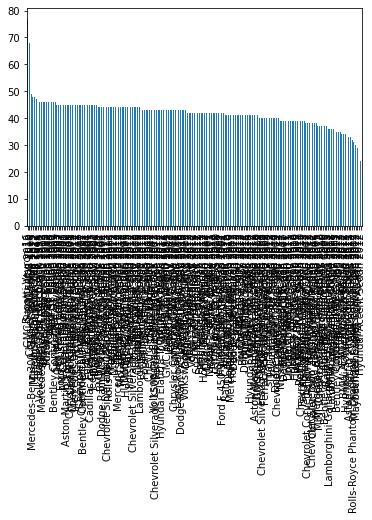

In [9]:
train_df['category'].value_counts().plot.bar()

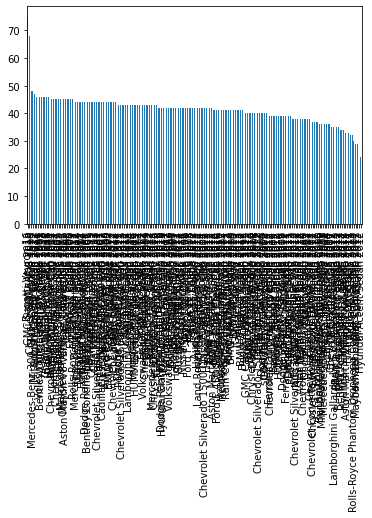

In [10]:
validate_df['category'].value_counts().plot.bar()

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest',
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 8144 validated image filenames belonging to 195 classes.


In [12]:
validation_datagen = ImageDataGenerator(
    # fill_mode='nearest',
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TEST_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 8041 validated image filenames belonging to 195 classes.


In [13]:
train_generator.image_shape

(128, 128, 3)

In [14]:
NUM_CLASSES = len(train_df['category'].value_counts())
print(NUM_CLASSES)

195


In [15]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# classifier = None
# classifier = Sequential([
#     layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Flatten(),
#     layers.Dense(512),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# classifier = None
# classifier = Sequential([
#     layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=train_generator.image_shape),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.001),
#     layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.001),
#     layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.001),
#     layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Flatten(),
#     layers.Dropout(0.001),
#     layers.Dense(512),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

import copy
untrained_layers = copy.deepcopy([classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights(),
                                  classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX+1].name).get_weights()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      21632     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
254/254 [==============================] - 44s 156ms/step - loss: 5.6412 - accuracy: 0.0072 - auc: 0.5206 - val_loss: 7.2640 - val_accuracy: 0.0102 - val_auc: 0.5289
Epoch 2/1000
254/254 [==============================] - 39s 155ms/step - loss: 5.2327 - accuracy: 0.0178 - auc: 0.6000 - val_loss: 6.3613 - val_accuracy: 0.0092 - val_auc: 0.5237
Epoch 3/1000
254/254 [==============================] - 40s 157ms/step - loss: 5.1300 - accuracy: 0.0192 - auc: 0.6309 - val_loss: 6.1315 - val_accuracy: 0.0177 - val_auc: 0.5717
Epoch 4/1000
254/254 [==============================] - 39s 156ms/step - loss: 5.0088 - accuracy: 0.0289 - auc: 0.6638 - val_loss: 5.5072 - val_accuracy: 0.0214 - val_auc: 0.5937
Epoch 5/1000
254/254 [==============================] - 40s 156ms/step - loss: 4.8840 - accuracy: 0.0400 - auc: 0.6945 - val_loss: 5.2103 - val_accuracy: 0.0316 - val_auc: 0.6406
Epoch 6/1000
254/254 [==============================] - 40s 157ms/step - loss: 4.7808 - accuracy: 0.0465 

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
254/254 [==============================] - 43s 168ms/step - loss: 5.6960 - accuracy: 0.0067 - auc: 0.5197 - val_loss: 5.4581 - val_accuracy: 0.0127 - val_auc: 0.5726
Epoch 2/1000
254/254 [==============================] - 43s 169ms/step - loss: 5.2747 - accuracy: 0.0167 - auc: 0.5867 - val_loss: 5.3371 - val_accuracy: 0.0134 - val_auc: 0.5975
Epoch 3/1000
254/254 [==============================] - 42s 165ms/step - loss: 5.1909 - accuracy: 0.0156 - auc: 0.6075 - val_loss: 5.6225 - val_accuracy: 0.0111 - val_auc: 0.5631
Epoch 4/1000
254/254 [==============================] - 43s 167ms/step - loss: 5.0848 - accuracy: 0.0220 - auc: 0.6393 - val_loss: 5.1873 - val_accuracy: 0.0207 - val_auc: 0.6173
Epoch 5/1000
254/254 [==============================] - 42s 167ms/step - loss: 4.9963 - accuracy: 0.0287 - auc: 0.6629 - val_loss: 5.1740 - val_accuracy: 0.0245 - val_auc: 0.6312
Epoch 6/1000
254/254 [==============================] - 42s 167ms/step - loss: 4.9507 - accuracy: 0.0321 

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
254/254 [==============================] - 47s 166ms/step - loss: 5.7062 - accuracy: 0.0058 - auc: 0.5236 - val_loss: 6.2256 - val_accuracy: 0.0106 - val_auc: 0.5302
Epoch 2/1000
254/254 [==============================] - 42s 166ms/step - loss: 5.2818 - accuracy: 0.0119 - auc: 0.5902 - val_loss: 6.4454 - val_accuracy: 0.0076 - val_auc: 0.5267
Epoch 3/1000
254/254 [==============================] - 43s 168ms/step - loss: 5.1815 - accuracy: 0.0162 - auc: 0.6128 - val_loss: 5.3654 - val_accuracy: 0.0151 - val_auc: 0.5862
Epoch 4/1000
254/254 [==============================] - 42s 167ms/step - loss: 5.0873 - accuracy: 0.0215 - auc: 0.6374 - val_loss: 5.1699 - val_accuracy: 0.0260 - val_auc: 0.6247
Epoch 5/1000
254/254 [==============================] - 43s 168ms/step - loss: 5.0076 - accuracy: 0.0310 - auc: 0.6632 - val_loss: 5.0983 - val_accuracy: 0.0268 - val_auc: 0.6433
Epoch 6/1000
254/254 [==============================] - 43s 170ms/step - loss: 4.9371 - accuracy: 0.0347 

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
254/254 [==============================] - 47s 165ms/step - loss: 5.7201 - accuracy: 0.0075 - auc: 0.5104 - val_loss: 5.4586 - val_accuracy: 0.0085 - val_auc: 0.5435
Epoch 2/1000
254/254 [==============================] - 41s 163ms/step - loss: 5.3900 - accuracy: 0.0077 - auc: 0.5469 - val_loss: 6.1483 - val_accuracy: 0.0090 - val_auc: 0.5369
Epoch 3/1000
254/254 [==============================] - 42s 164ms/step - loss: 5.3109 - accuracy: 0.0124 - auc: 0.5639 - val_loss: 7.5041 - val_accuracy: 0.0071 - val_auc: 0.5154
Epoch 4/1000
254/254 [==============================] - 41s 163ms/step - loss: 5.2445 - accuracy: 0.0149 - auc: 0.5871 - val_loss: 5.5194 - val_accuracy: 0.0116 - val_auc: 0.5591
Epoch 5/1000
254/254 [==============================] - 41s 163ms/step - loss: 5.2072 - accuracy: 0.0151 - auc: 0.5985 - val_loss: 5.3691 - val_accuracy: 0.0121 - val_auc: 0.5681
Epoch 6/1000
254/254 [==============================] - 41s 163ms/step - loss: 5.1567 - accuracy: 0.0204 

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
254/254 [==============================] - 44s 155ms/step - loss: 5.7276 - accuracy: 0.0050 - auc: 0.5104 - val_loss: 5.7937 - val_accuracy: 0.0071 - val_auc: 0.5273
Epoch 2/1000
254/254 [==============================] - 39s 154ms/step - loss: 5.3922 - accuracy: 0.0110 - auc: 0.5469 - val_loss: 6.2176 - val_accuracy: 0.0086 - val_auc: 0.5253
Epoch 3/1000
254/254 [==============================] - 38s 150ms/step - loss: 5.3152 - accuracy: 0.0133 - auc: 0.5725 - val_loss: 5.8163 - val_accuracy: 0.0112 - val_auc: 0.5544
Epoch 4/1000
254/254 [==============================] - 38s 150ms/step - loss: 5.2333 - accuracy: 0.0167 - auc: 0.5934 - val_loss: 5.3872 - val_accuracy: 0.0142 - val_auc: 0.5745
Epoch 5/1000
254/254 [==============================] - 38s 151ms/step - loss: 5.1645 - accuracy: 0.0198 - auc: 0.6147 - val_loss: 5.2460 - val_accuracy: 0.0190 - val_auc: 0.5967
Epoch 6/1000
254/254 [==============================] - 39s 152ms/step - loss: 5.1153 - accuracy: 0.0191 

In [ ]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

Start time = 694.65965808
Finish time = 3575.23298412
Training time = 2880.5733260399998


In [ ]:
import pickle

trained_layers = copy.deepcopy([classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights(),
                                classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX+1].name).get_weights()])
hist.history['untrained_layers'] = untrained_layers
hist.history['trained_layers'] = trained_layers

with open('stanfordcars-{}-history-kernel-{}.p'.format(ITERATION, GABOR_WIDTH),'wb') as fp:
    pickle.dump(hist.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

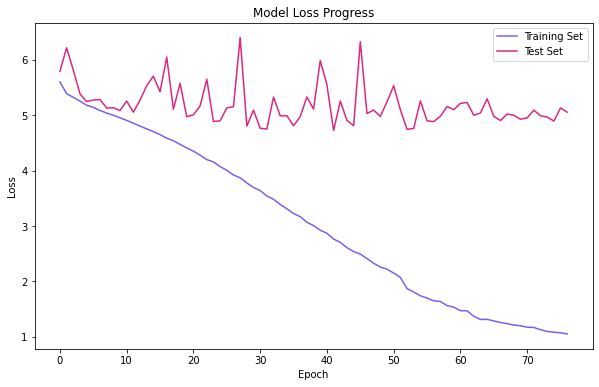

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('stanfordcars-{}-loss-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

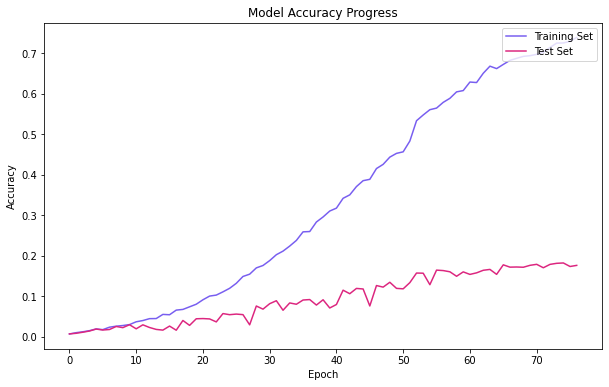

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('stanfordcars-{}-accuracy-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

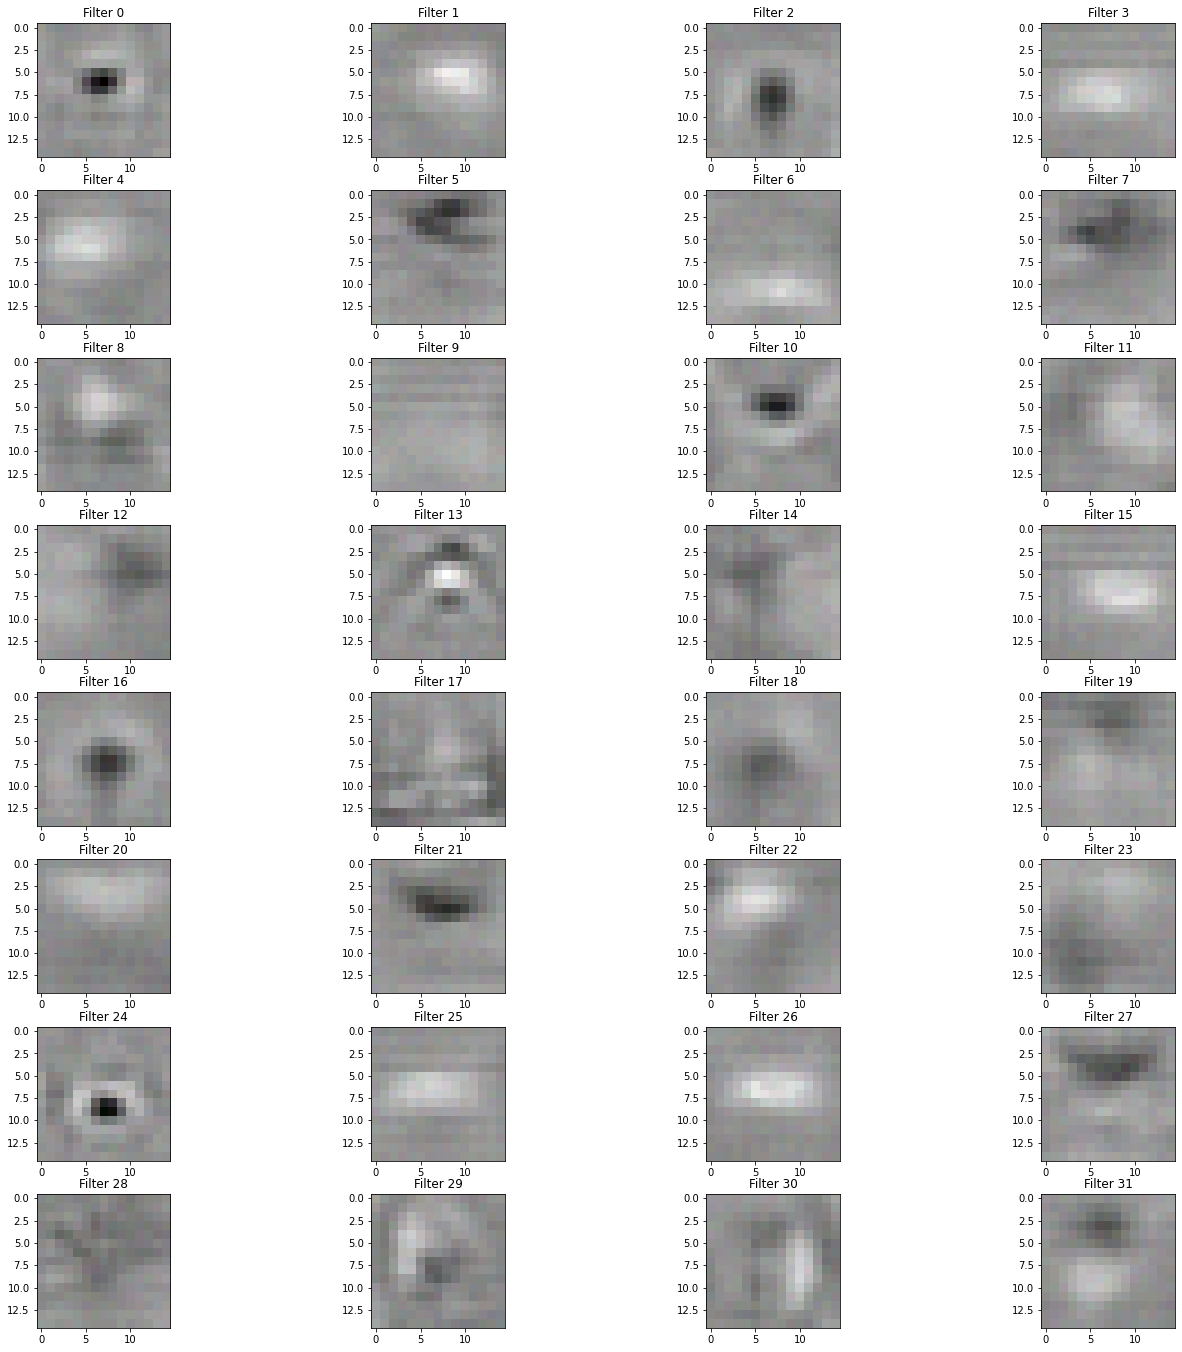

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("stanfordcars-{}-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

-0.72460514 0.5467731


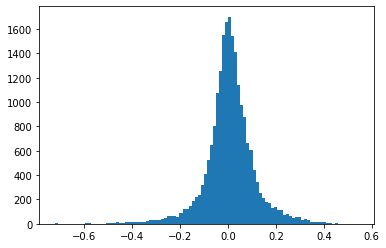

In [ ]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

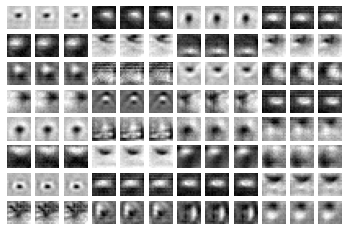

In [ ]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("stanfordcars-{}-channelwise-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)